In [2]:
import qiskit

In [3]:
from qiskit_machine_learning.algorithms import regressors

In [4]:
import numpy as np

In [1]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap

In [5]:
import pymatgen as mg
import pymatgen.analysis.diffraction as anadi
import pymatgen.analysis.diffraction.xrd as xrd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [23]:
from qiskit_machine_learning.kernels import QuantumKernel

In [7]:
patt_xrd = xrd.XRDCalculator('CuKa')

In [8]:
train_path='/Users/junjiehu/Desktop/202210test/train/'

test_path='/Users/junjiehu/Desktop/202210test/test/'

In [19]:
base_pxrd_s=mg.core.Structure.from_file(train_path+'00000/CONTCAR')
base_pxrd=patt_xrd.get_pattern(base_pxrd_s)

In [9]:
global sample_num, rmat_num, series_num
sample_num=1 #output of G
rmat_num=32 

In [6]:
def get_energy(folder):
    energy_string=os.popen('grep TOTEN '+folder+'/OUTCAR | tail -1').read().split(' ')[-2]
    energy=round(np.float64(float(energy_string)),5)
    return energy

def linear_transform(energy):
    global extend_num, move_num
    energy_transform=(energy-move_num)*extend_num
    return energy_transform

def inverse_transform(energy_transform):
    global extend_num, move_num
    energy=energy_transform/extend_num+move_num
    return energy

def get_energy_per_atom(energy):
    energy_per_atom=energy/atoms_num
    return energy_per_atom

In [10]:
global extend_num, move_num

In [11]:
extend_num=1000

In [12]:
move_num=get_energy(train_path+'00000/')
print(move_num)

-122.69044


In [16]:
def tomgStructure(folder):
    POSfile = folder+'/CONTCAR'      
    R_mgS = mg.core.Structure.from_file(POSfile)
    return R_mgS

###
##input_data_to_model
###
def get_xrdmat3(mgStructure):
    global rmat_num
    xrd_data4 = patt_xrd.get_pattern(mgStructure)
    xrd_data4.y= xrd_data4.y-base_pxrd.y
    i_column = rmat_num
    xxx = []
    yyy = []
    mat4 = []
    xrd_i = len(xrd_data4)
    for i in range(xrd_i):
        if abs(xrd_data4.y[i]) > 0.00001:
            xxx.append(xrd_data4.x[i])
            yyy.append(xrd_data4.y[i])
    mat4.append(np.asarray(xxx))
    mat4.append(np.asarray(yyy))
    mat4 = np.asarray(mat4)
    
    xrd_x=[]
    xrd_y=[]
    xrd_mat4=[]
    xrow=len(mat4[0])
    
    if xrow < i_column:
        for i in mat4[0]:
            xrd_x.append(i)
        for j in mat4[1]:
            xrd_y.append(j)
        for i in range(0,i_column-xrow):
            xrd_x.append(0)
            xrd_y.append(0)
        xrd_x=np.asarray(xrd_x)
        xrd_y=np.asarray(xrd_y)
    if xrow > i_column:
        xrd_x=mat4[0][:i_column]
        xrd_y=mat4[1][:i_column]
    if xrow == i_column:
        xrd_x= mat4[0]
        xrd_y= mat4[1]
        
    
    xrd_x=np.sin(np.dot(1/180*np.pi,xrd_x))
    xrd_y=np.dot(100,xrd_y)
    xrd_mat4.append(xrd_x)
    xrd_mat4.append(xrd_y)
    xrd_mat4=np.array(xrd_mat4)
    return xrd_mat4
###
##input_data_as_knowlegde
###
'''
def get_Gibbs(folder):
    energy_string=os.popen('grep TOTEN '+folder+'/OUTCAR | tail -1').read().split(' ')[-2]
    Gibbs=np.float64(float(energy_string))
    Gibbs=round(Gibbs,6)
    return Gibbs
'''
##
###
def get_atoms_num(folder2):
    xxx=tomgStructure(folder2)
    anum=len(xxx.sites)
    return anum


###
##input_data_for_G
###
def QSVMmat(Random_Structure):
    global rmat_num
    RS_xrdmat = get_xrdmat3(Random_Structure)
    multimat3_RS =  np.zeros((rmat_num, 2),dtype='float32')
    multimat3_RS = np.asarray(RS_xrdmat.T)
    return multimat3_RS

In [17]:
def model_input_svm(floder):
    #input
    model_input=[]
    model_input_mgs=tomgStructure(floder)
    model_input_mgs=QSVMmat(model_input_mgs)
    model_input.append(model_input_mgs)
    model_input=np.asarray(model_input)
    model_input=model_input.reshape(model_input.size)
    return model_input

In [22]:
(model_input_svm(train_path+'00445')).shape

(64,)

In [27]:
seed = 1376
algorithm_globals.random_seed = seed

In [24]:
adhoc_dimension = 6

In [25]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

In [28]:
adhoc_backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
)

In [29]:
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

In [30]:
qsvr1= regressors.QSVR(quantum_kernel=adhoc_kernel)

In [ ]:
#training_features, training_labels, test_features, test_labels = \
#    ad_hoc_data(
#            training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3)



In [31]:
flag_set=[]
file_path_set=[]
work_path=train_path
for m1,n1,fname in os.walk(work_path):
    for ieach in n1:
        flag_set.append(ieach)
        ieach=work_path+ieach
        file_path_set.append(ieach)

In [32]:
energy_label=[]
Y_train=[]
for pnum in range(len(file_path_set)):
    try:
        eee = get_energy(file_path_set[pnum])
        eee = [eee]
        energy_label.append(eee)
        Y_train.append(linear_transform(eee))
    except:
        print('energy label error: ', file_path_set[pnum])

In [33]:
X_train=[]
for pnum in range(len(file_path_set)):
    try:
        X_train.append(model_input_svm(file_path_set[pnum]))
    except:
        print('inputX error:', file_path_set[pnum])

In [34]:
flag_set_test=[]
file_path_set_test=[]
work_path=test_path
for m1,n1,fname in os.walk(work_path):
    for ieach in n1:
        flag_set_test.append(ieach)
        ieach=work_path+ieach
        file_path_set_test.append(ieach)

In [35]:
energy_label_test=[]
Y_test=[]
for pnum in range(len(file_path_set_test)):
    try:
        eee = get_energy(file_path_set_test[pnum])
        eee = [eee]
        energy_label.append(eee)
        Y_test.append(linear_transform(eee))
    except:
        print('energy label error: ', file_path_set_test[pnum] )

In [36]:
X_test=[]
for pnum in range(len(file_path_set_test)):
    try:
        X_test.append(model_input_svm(file_path_set_test[pnum]))
    except:
        print('inputX error:', file_path_set_test[pnum])

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca1 = PCA(n_components = 6)

In [40]:
pca1.fit(X_train)

PCA(n_components=6)

In [46]:
X_train_pca = pca1.transform(X_train)

In [42]:
X_test_pca = pca1.transform(X_test)

In [43]:
print(X_train_pca.shape,X_test_pca.shape)

(500, 6) (500, 6)


In [48]:
qsvr1.fit(X_train_pca,Y_train)

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/svm/_base.py:296: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


QSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     max_iter=-1,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7fed0999bfd0>,
     shrinking=True, tol=0.001, verbose=False)

In [49]:
y_predict_train = qsvr1.predict(X_train_pca)

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [50]:
def cal_MAE(predict, label):
    MAEerr=[]
    for i in range(len(label)):
        err = inverse_transform(predict[i]) - inverse_transform(label[i])
        MAEerr.append(err)
    out = np.mean(np.abs(np.asarray(MAEerr)))
    return out

In [51]:
cal_MAE(y_predict_train, Y_train)

0.002415826179314763

In [52]:
dir_file = '/Users/junjiehu/Mlearning/MaterialsML/DFT-bluk-cpx222/'

In [53]:
flag_set=[]
file_path_set=[]
work_path=dir_file
for m1,n1,fname in os.walk(work_path):
    for ieach in n1:
        flag_set.append(ieach)
        ieach=work_path+ieach
        file_path_set.append(ieach)

In [54]:
energy_label=[]
Y=[]
for pnum in range(len(file_path_set)):
    try:
        eee = get_energy(file_path_set[pnum])
        eee = [eee]
        energy_label.append(eee)
        Y.append(linear_transform(eee))
    except:
        print('energy label error: ', file_path_set[pnum] )

In [55]:
X=[]
for pnum in range(len(file_path_set)):
    try:
        X.append(model_input_svm(file_path_set[pnum]))
    except:
        print('inputX error:', file_path_set[pnum])

In [56]:
X_pca = pca1.transform(X)

In [57]:
y_predict = qsvr1.predict(X_pca)

In [58]:
cal_MAE(y_predict,Y)

0.003657033066448406

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

In [63]:
def extract(flodername):    
    with open(flodername+'/'+'CONTCAR') as f:
        lol=[line.strip().split('\n') for line in f]#逐行读取，并存储为数组结构
    matr_s_o=[]#存放晶格常数的3*3数组    
    matr_o=[]
    
    formula_element=''#存放原子类型
    amount_element=''#存放晶胞中原子个数
    
    matr_data_o=[]
    matr_data_0=[]
    matr_data=[]
    for i in lol[2:5]:

        jjj=[]

        for j in i[0].split(' '):
            if j !='':
                jjj.append(j)

        matr_s_o.append(jjj)
   
    for k in matr_s_o:
        matr_o.append([float(l) for l in k])
    
    amount_element=lol[5]
    
    for n in lol[9:49]:#文件第10行开始读数据

        n[0]=n[0][:-10]
        mmm=[]
        for m in n[0].split(' '):
        #        print(m)
            if m !='':
                mmm.append(m)
           # print(mmm)
        matr_data_o.append(mmm)
        
    for p in matr_data_o:
        matr_data_0.append([float(q) for q in p]) 
    
    matr_out=matr_o
    amount_element_out=amount_element[0]
    matr_data_0=matr_data_0
    
    return matr_out, amount_element_out, matr_data_0

In [59]:
def get_tSNE_input(path_):
    input_vector_poscar=[]
    a,b,c=extract(path_)
    #energy=get_energy(path_)
    siteZero=np.asarray([0.5,0.5,0.5])
    Br_I_atoms=c[16:]
    coordinate=np.dot(np.asarray(Br_I_atoms),np.asarray(a))
    #print(len(coordinate))
    for i in range(len(coordinate)):
        input_vector=[]
        if i <=18:
            #print(coordinate[i])
            input_vector.append(2.8)
            for x in coordinate[i]:
                input_vector.append(x)
            input_vector_poscar.append(input_vector)
        else:
            input_vector.append(2.5)
            for x in coordinate[i]:
                input_vector.append(x)
            input_vector_poscar.append(input_vector)
    input_vector_poscar=np.asarray(input_vector_poscar)
    input_vector_poscar=input_vector_poscar.reshape((24*4),order="C")
    return input_vector_poscar

In [64]:
tSNE_input=[]
for pnum in range(len(file_path_set)):
    try:
        path_=file_path_set[pnum]
        tSNE_input.append(get_tSNE_input(path_))
    except:
        print('error:',file_path_set[pnum])

In [66]:
from sklearn.manifold import TSNE

In [67]:
tsne = TSNE(min_grad_norm=1e-3,init='pca',method='exact',angle=1,early_exaggeration=5,n_iter=1000)

In [68]:
tSNE_input = np.asarray(tSNE_input)
tsne_output = tsne.fit_transform(tSNE_input)

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [69]:
lx = tsne_output.T[0]
ly = tsne_output.T[1]

In [73]:
DFT_label=inverse_transform(np.asarray(Y))
qsvr_predict=inverse_transform(np.asarray(y_predict))

In [74]:
minz = np.min(qsvr_predict)
maxz = np.max(qsvr_predict)
print('minimum:',minz)
print('maximum:',maxz)
print('scale:',maxz-minz)
a1 = minz + 0.2 * (maxz-minz)
a2 = minz + 0.4 * (maxz-minz)
a3 = minz + 0.6 * (maxz-minz)
a4 = minz + 0.8 * (maxz-minz)
print(minz,a1,a2,a3,a4,maxz)

minimum: -122.70476986301841
maximum: -122.68840903913419
scale: 0.016360823884227216
-122.70476986301841 -122.70149769824157 -122.69822553346472 -122.69495336868788 -122.69168120391103 -122.68840903913419


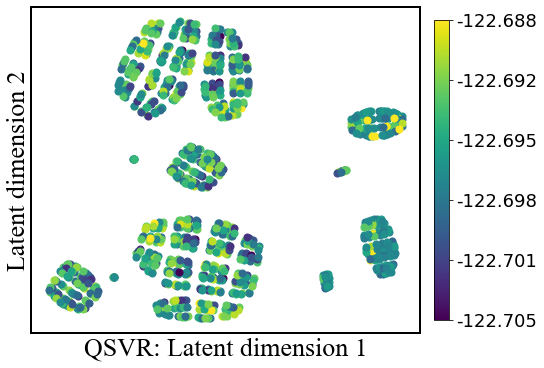

In [76]:
f=plt.figure(figsize=(8.5,6))
ax1=plt.gca()

#j=1088
for i in range(len(lx)):
    color1=cm.viridis_r(int(256*(qsvr_predict[i]-minz)/(maxz-minz)))
    a1=ax1.scatter(lx[i],ly[i],color=color1,s=50)
    #d=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
cb=plt.colorbar(a1,ax=ax1,shrink=0.92,pad=0.03)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_yticklabels(['-122.705', '-122.701', '-122.698', '-122.695', '-122.692', '-122.688'])
cb.ax.tick_params(labelsize=18)
ax1.set_xlabel('QSVR: Latent dimension 1',fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.set_ylabel('Latent dimension 2',labelpad=0,fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.tick_params(labelsize=22)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.set_xticks(())
ax1.set_yticks(())
plt.savefig('QSVRmodel-2.jpg')

In [ ]:
#ansatz = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3)

In [ ]:
#backend = Aer.get_backend('statevector_simulator')

In [ ]:
t#raining_data = {'A': np.asarray([[0.324],[0.565],[0.324],[0.565]]),'B': np.asarray([[1.324],[1.565],[0.324],[0.565]])}

In [ ]:
#testing_data = np.asarray([1,2,3,4])

In [ ]:
#num_qubits = 1

In [ ]:
#qqsvr1 = regressors.QSVR(quantum_kernel=)

In [ ]:
#from qiskit import QuantumInstance

In [ ]:
#qqsvr1.fit(training_data,testing_data,)

In [ ]:
#qsvr1 = regressors.QSVR()

In [ ]:
#help(regressors.QSVR())

In [ ]:
#training_data = np.asarray([[0.324,0.565,0.231,0.756,0.324,0.534,0.132,0.344],
                 [1.324,1.565,1.231,1.756,1.324,1.534,1.132,1.344]])

In [ ]:
#testing_data = np.asarray([[0.024], [1,777]])

In [ ]:
#qsvr1.fit(training_data,testing_data)

In [ ]:
#help(qsvr1)